In [66]:
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Concatenate, ZeroPadding2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

In [41]:
def downsample(filters, size):
    model = Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU())
    return model


def upsample(filters, size):
    model = Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU())
    return model

In [132]:
class Generator(Model):
    def __init__(self, 
                 num_down_layers, 
                 down_filters, 
                 down_sizes,
                 up_filters,
                 up_sizes,
                 output_channels, 
                 **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.down_layers = []
        for i in range(num_down_layers):
            filters = down_filters[i]
            size = down_sizes[i]
            down_layer = downsample(filters, size)
            self.down_layers.append(down_layer)
        
        self.up_layers = []
        for i in range(num_down_layers - 1):
            filters = up_filters[i]
            size = up_sizes[i]
            up_layer = upsample(filters, size)
            self.up_layers.append(up_layer)
            
        self.output_layer = Conv2DTranspose(output_channels, 
                                            4,
                                            strides=2,
                                            padding='same',
                                            activation='tanh')
        
    def call(self, inputs):
        x = inputs
        skips = []
        for down_layer in self.down_layers:
            x = down_layer(x)
            skips.append(x)
                
        skips = list(reversed(skips[:-1]))
            
        for i in range(len(self.up_layers)):
            up_layer = self.up_layers[i]
            x = up_layer(x)
            skip_output = skips[i]
            x = Concatenate()([x, skip_output])
                
        return self.output_layer(x)
        
        
class Discriminator(Model):
    def __init__(self, 
                 num_down_disc,
                 down_filters, 
                 down_sizes,
                 **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.down_layers = []
        for i in range(num_down_disc):
            filters = down_filters[i]
            size = down_sizes[i]
            down_layer = downsample(filters, size)
            self.down_layers.append(down_layer)
            
        self.zero_pad1 = ZeroPadding2D()
        
        self.conv_spec = Conv2D(514, 4, strides=1)
        self.instance_norm = tfa.layers.InstanceNormalization()
        self.leaky_relu = LeakyReLU()
        self.zero_pad2 = ZeroPadding2D()
        self.output_layer = Conv2D(1, 4, strides = 1)
        
    def call(self, inputs):
        x = inputs
        for layer in self.down_layers:
            x = layer(x)
        x = self.zero_pad1(x)
        x = self.conv_spec(x)
        x = self.instance_norm(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.output_layer(x)

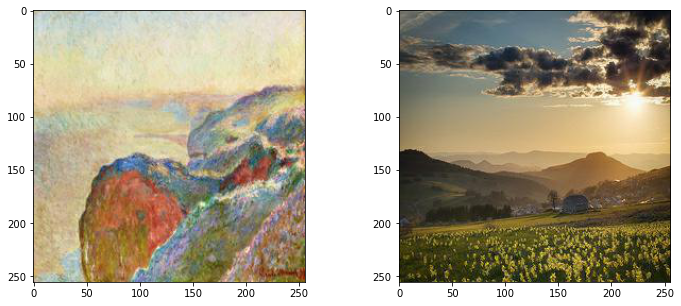

In [133]:
monet_path = os.path.join('datasets', 'monet', 'monet_jpg', '000c1e3bff.jpg')
monet_img = load_img(monet_path)
monet_img = img_to_array(monet_img)


photo_path = os.path.join('datasets', 'monet', 'photo_jpg', '00068bc07f.jpg')
photo_img = load_img(photo_path)
photo_img = img_to_array(photo_img)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(np.uint8(monet_img))
ax[1].imshow(np.uint8(photo_img))

In [141]:
num_down_layers = 8
down_filters = [64, 128, 256, 512, 512, 512, 512, 512]
down_size = [4, 4, 4, 4, 4, 4, 4, 4]
up_filters = [512, 512, 512, 512, 256, 128, 64]
up_size = [4, 4, 4, 4, 4, 4, 4]
output_channels = 3


monet_generator = Generator(num_down_layers,
                            down_filters,
                            down_size,
                            up_filters,
                            up_size,
                            output_channels)

photo_generator = Generator(num_down_layers,
                            down_filters,
                            down_size,
                            up_filters,
                            up_size,
                            output_channels)


num_down_disc = 3
down_filters_disc = [64, 128, 256]
down_sizes_disc = [4, 4, 4]

monet_discriminator = Discriminator(num_down_disc=num_down_disc,
                                    down_filters=down_filters_disc, 
                                    down_sizes=down_sizes_disc)

photo_discriminator = Discriminator(num_down_disc=num_down_disc,
                                    down_filters=down_filters_disc, 
                                    down_sizes=down_sizes_disc)

In [137]:
x = Input(shape=(256, 256, 3))
monet_generator(x)
monet_generator.summary()

Model: "generator_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_238 (Sequential)  (None, 128, 128, 64)      3200      
_________________________________________________________________
sequential_239 (Sequential)  (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_240 (Sequential)  (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_241 (Sequential)  (None, 16, 16, 512)       2098176   
_________________________________________________________________
sequential_242 (Sequential)  (None, 8, 8, 512)         4195328   
_________________________________________________________________
sequential_243 (Sequential)  (None, 4, 4, 512)         4195328   
_________________________________________________________________
sequential_244 (Sequential)  (None, 2, 2, 512)        

In [138]:
x_disc = Input(shape=(256, 256, 3))
monet_discriminator(x_disc)
monet_discriminator.summary()

Model: "discriminator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_253 (Sequential)  (None, 128, 128, 64)      3200      
_________________________________________________________________
sequential_254 (Sequential)  (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_255 (Sequential)  (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 31, 31, 514)       2105858   
_________________________________________________________________
instance_normalization_256 ( (None, 31, 31, 514)       1028      
_________________________________________________________________
leaky_re_lu_255 (LeakyReLU)  (None, 31, 31, 514)   

In [143]:
class CycleGAN(Model):
    def __init__(self,
                 monet_generator,
                 photo_generator,
                 monet_discriminator,
                 photo_discriminator,
                 lambda_cycle=10,
                 **kwargs):
        super(CycleGan, self).__init__(**kwargs)
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
                monet_gen_optimizer,
                photo_gen_optimizer, 
                monet_disc_optimizer,
                photo_dics_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn):
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer 
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn